In [1]:
'''Helper'''
import pandas as pd
import numpy as np
import time
import joblib
import pickle
import re
import string
import unicodedata
import matplotlib.pyplot as plt
from numpy import argmax
import scipy
# import spacy
from sklearn.metrics.pairwise import cosine_similarity

'''Models'''
from transformers import pipeline
# from onnx_transformers import pipeline # to run this -- downgrade transformers library to 3.2.0

'''Display'''
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.1f' % x)
pd.set_option("max_colwidth", 150)

In [2]:
!pip show transformers

Name: transformers
Version: 4.10.0
Summary: State-of-the-art Natural Language Processing for TensorFlow 2.0 and PyTorch
Home-page: https://github.com/huggingface/transformers
Author: Thomas Wolf, Lysandre Debut, Victor Sanh, Julien Chaumond, Sam Shleifer, Patrick von Platen, Sylvain Gugger, Suraj Patil, Stas Bekman, Google AI Language Team Authors, Open AI team Authors, Facebook AI Authors, Carnegie Mellon University Authors
Author-email: thomas@huggingface.co
License: Apache
Location: /opt/conda/lib/python3.7/site-packages
Requires: sacremoses, importlib-metadata, packaging, regex, numpy, requests, tokenizers, filelock, huggingface-hub, tqdm, pyyaml
Required-by: sentence-transformers


In [3]:
# !pip install transformers==4.10.0

### Input data

In [3]:
df = pd.read_pickle("./data/preprocess_mnet_test.pkl")

df.drop_duplicates('natid', keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.shape)
# df.head()

(1258, 8)


count     1258
mean      3607
std       2295
min        481
25%       2208
50%       3130
75%       4358
max      39004
Name: clean_summary, dtype: int64

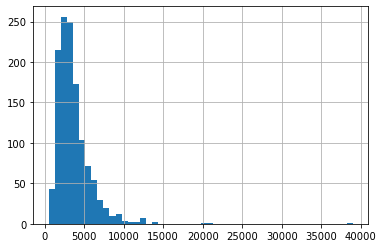

In [4]:
df.clean_summary.str.len().hist(bins=50)
df.clean_summary.str.len().describe().apply(int)

### Generate multi-labels Tier 1 for Test dataset

In [5]:
model = 'joeddav/bart-large-mnli-yahoo-answers'

classifier = pipeline("zero-shot-classification", 
                      model = model)

# candidate_labels = df.tier1.unique().tolist()
candidate_labels_t2 = df.tier2.unique().tolist()
print(len(candidate_labels_t2))

205


In [6]:
prim_labels = []
sec_labels = []
ter_labels = []

prim_scores = []
sec_scores = []
ter_scores = []

begin = 400 # 200 # 100 # 0 # 1000 # 800 # 600 #  
end = 600 # 400 # 200 # 100 # 1258 # 1000 # 800 #   
df[begin:end]

,natid,pub_date,category,tier1,tier2,summary,clean_summary,label
400,blogandpostid/blog/post/4983-5f92d6f7307874000643b397,2020-12-07,Healthy Living,Shopping,Sales and Promotions,The 7 Best Space Heaters To Keep You Warm This Winter.<p>There are a lot of things to consider when choosing the best space heater for you. For on...,"7 best space heaters warm winter. lot things consider choosing best space heater you. one, need consider big space want heat, space heaters come d...",13
401,blogandpostid/blog/post/50786-5fc57ecfc2f2cc00065dfcab,2020-11-30,Television,Hobbies & Interests,Games and Puzzles,"‘Queen’s Gambit’ Rules U.S. Streaming Chart; Sparks Chess Sales.[id=0]<p>Netflix’s<fbs-ticker data-name=""NFLX"" data-href=""https://www.forbes.com/c...",queen's gambit' rules usa streaming chart; sparks chess sales. netflix's nflx queen's gambit continued winning streak thanksgiving holiday viewed ...,26
402,blogandpostid/blog/post/7076-5fdb7861ea902300064d38d7,2020-12-17,Business and Finance,Automotive,Auto Type,A Loveletter To Intelligent Systems From My First 100 Hours Ownership Of My Tesla X..<p>I feel privileged to be able to own a tiny slice of our fu...,"loveletter intelligent systems 100 hours ownership tesla x.. feel privileged able tiny slice future tesla x. hours in, illustrates substantial por...",14
403,blogandpostid/blog/post/2214-5f29b5b27fd9970006e48ac1,2020-08-04,Sports,Sports,Baseball,Wild Wild West League Offers Rare Chance To Attend Baseball Games During Pandemic.[id=0]<p>It’s the oddest of odd times in sports these days. As t...,wild wild west league offers rare chance attend baseball games pandemic. oddest odd times sports days. coronavirus pandemic continues health offic...,18
404,blogandpostid/blog/post/4828-5f3b373138aa5e0006fe35e4,2020-08-18,Style and Fashion,Style & Fashion,Fashion Trends,"Sustainable Fashion Pioneer, Maria Cornejo, Finds A New Home In The Hamptons.[id=0]<p>When <a href=""https://www.instagram.com/zeromcornejo/?hl=en""...","sustainable fashion pioneer, maria cornejo, finds new home hamptons. maria cornejo proposed sustainable way creating garments speaking tongues. pe...",17
...,...,...,...,...,...,...,...,...
595,blogandpostid/blog/post/5801-5f30438ceaa5fe00069c4829,2020-08-10,News and Politics,Home & Garden,Gardening,"Learn How To Cultivate Your Own Cannabis With Tips From A Pro Gardener.[id=1]<p>Backyard gardening <a href=""https://www.newyorker.com/culture/onwa...",learn cultivate cannabis tips pro gardener. backyard gardening bloomed coronavirus forced stay home start growing season year. charlotte mendelson...,25
596,blogandpostid/blog/post/6609-5f2812556715e5000716b77e,2020-08-03,Sports,Medical Health,Diseases and Conditions,Orlando Magic’s Jonathan Isaac Suffers Torn ACL.[id=0]<p>The Orlando Magic suffered a major loss on Sunday when Jonathan Isaac went down with what...,orlando magic's jonathan isaac suffers torn acl. orlando magic suffered major loss sunday jonathan isaac went diagnosed torn acl left knee. news r...,16
597,blogandpostid/blog/post/50531-5f92ad1530787400062f55e6,2020-10-23,News and Politics,News and Politics,Politics,"The Biggest Falsehoods Of The Final Trump-Biden Presidential Debate.<h2 class=""topline-heading"">Topline</h2><p>While the final debate between Pres...",biggest falsehoods final trump-biden presidential debate. topline final debate president donald trump challenger joe biden significantly sedate co...,0
598,blogandpostid/blog/post/6287-60d0d67997480600069001d4,2021-06-21,Food and Drink,Style & Fashion,Women's Fashion,"North Block: Napa Valley’s Newest Destination For Fine Dining, Boutique Lodging And More.[id=0]<p>Summer is in full swing in Napa Valley and with ...","north block: napa valley's newest destination fine dining, boutique lodging more. summer swing napa valley comes booming restaurant scene boasts c...",17


In [7]:
start_time = time.time()

art_list = df.clean_summary[begin:end].tolist()

for i in range(len(art_list)):

    res = classifier(art_list[i][:3200], candidate_labels_t2, multi_label=True)
    
    prim_labels.append(res['labels'][0])
    sec_labels.append(res['labels'][1])
    ter_labels.append(res['labels'][2])
    
    prim_scores.append(res['scores'][0])
    sec_scores.append(res['scores'][1])
    ter_scores.append(res['scores'][2])

print("time (mins) - ", round((time.time() - start_time)/60, 2), "\n") # runtime: 100 rows - 65 - 72 mins #4.49

time (mins) -  132.07 



In [8]:
ml_data = pd.DataFrame(df[['natid', 'category', 'tier1', 'tier2', 'clean_summary']][begin:end])
ml_data["prim_labels"] = prim_labels
ml_data["sec_labels"] = sec_labels
ml_data["ter_labels"] = ter_labels

ml_data["prim_prob"] = prim_scores
ml_data["sec_prob"] = sec_scores
ml_data["ter_prob"] = ter_scores

In [9]:
ml_data.to_csv("./mnet_test/ml_yahoo_t2_test_begin_"+str(begin)+".csv", index=False)

* Computation - 65 minutes for 100 articles with 205 labels. More unique labels = More time


* **Analyze results**
    

In [1]:
import glob
import pandas as pd

def pd_read_pattern(pattern):
    files = glob.glob(pattern)

    df = pd.DataFrame()
    for f in files:
        df = df.append(pd.read_csv(f))

    return df.reset_index(drop=True)

ml = pd_read_pattern('./mnet_test/ml_yahoo_t2_test_begin_*.csv')
ml.reset_index(drop=True, inplace=True)
ml.shape
# ml.to_csv("ml_inspect.csv", index=False)

(600, 11)

In [2]:
import joblib

natid_review = joblib.load("./mnet_test/natid_manual_review.joblib")
print(len(natid_review))

import numpy as np
ml["Manual Review"] = np.where(ml.natid.isin(natid_review), "Yes", "No")

ml.to_csv("./mnet_test/ml_inspect_t2_orig.csv", index=False)

56


In [3]:
ml.head()

,natid,category,tier1,tier2,clean_summary,prim_labels,sec_labels,ter_labels,prim_prob,sec_prob,ter_prob,Manual Review
0,blogandpostid/blog/post/4983-5f92d6f7307874000...,Healthy Living,Shopping,Sales and Promotions,7 best space heaters warm winter. lot things c...,Home Appliances,Consumer Electronics,Household Supplies,0.987671,0.977337,0.949797,No
1,blogandpostid/blog/post/50786-5fc57ecfc2f2cc00...,Television,Hobbies & Interests,Games and Puzzles,queen's gambit' rules usa streaming chart; spa...,Business,Industries,Sales and Promotions,0.975572,0.963487,0.934601,No
2,blogandpostid/blog/post/7076-5fdb7861ea9023000...,Business and Finance,Automotive,Auto Type,loveletter intelligent systems 100 hours owner...,Business,Industries,Economy,0.929867,0.840437,0.827201,No
3,blogandpostid/blog/post/2214-5f29b5b27fd997000...,Sports,Sports,Baseball,wild wild west league offers rare chance atten...,Diseases and Conditions,Vaccines,Wellness,0.918247,0.801541,0.795346,No
4,blogandpostid/blog/post/4828-5f3b373138aa5e000...,Style and Fashion,Style & Fashion,Fashion Trends,"sustainable fashion pioneer, maria cornejo, fi...",Business,Industries,Economy,0.978973,0.967865,0.957740,No


In [4]:
ml.tier2.value_counts()

College Education            20
Travel Type                  19
Business                     18
Auto Type                    17
Video Game Genres            16
                             ..
Indie and Arthouse Movies     1
Romance Movies                1
Home Improvement              1
Soap Opera TV                 1
Urban Contemporary Music      1
Name: tier2, Length: 166, dtype: int64

**Observation reg. mnet tier 2 data**:
* Tier1 = Business and Finance has just 3 corresponding unique Tier 2s = Business, Industries, Economy
    * Industry - how to distinguish between industry and non-industry articles? 
        * In training data - articles mentioning real estate, tech etc are tagged industries. (Makes sense)
        * But then articles talking about individual company's stocks or corporate culture are also tagged as industry (Contradictory)
    * Business - same as above
        * eye-balling suggests Business covers articles w/ topics - small business, corporate culture/leadership/soft-skills, how to run business
    * Economy - same as above
        * eye-balling suggests Economy covers articles w/ topics - economy, stocks, stimulus check

**Observation reg. predicted labels**:
* Primary label - most predicted = Business, Sec label - most predicted = Industry, Ter label - most predicted = Industry+Economy
    * But model is not able to differentiate between what is actually business and what is not. 
    * What is industry and what is not. 
    * What is economy and what is not
* Test data has 18 articles w/ Business. Predicted 206 articles got primary labels = Business. 
    * Because model is not able to differentiate well b/w business and non-business because of loose interpretation of Business - half of 206 may be wrong
    
Their grounds of dismissal:
* B&F predicted the most (they agreed)
* Video game tier1 has all computing as second label - so secondary is bad

In [5]:
# 34% articles getting Business label

ml.prim_labels.value_counts()

Business                   206
Computing                   39
Politics                    28
Diseases and Conditions     28
Wellness                    18
                          ... 
Cooking                      1
Career Planning              1
High Fashion                 1
Animation Movies             1
Hotel Properties             1
Name: prim_labels, Length: 88, dtype: int64

In [8]:
ml.prim_labels.value_counts()[:10]

Business                   206
Computing                   39
Politics                    28
Diseases and Conditions     28
Wellness                    18
PC Games                    14
Biological Sciences         13
Economy                     12
Alcoholic Beverages         11
Industries                  11
Name: prim_labels, dtype: int64

In [9]:
ml.sec_labels.value_counts()[:10]

Industries                 119
Business                    68
Economy                     24
Diseases and Conditions     20
Vaccines                    18
Sales and Promotions        17
Financial Planning          13
Computing                   13
Console Games               11
Environment                 11
Name: sec_labels, dtype: int64

In [10]:
ml.ter_labels.value_counts()[:10]

Industries                 76
Economy                    58
Business                   32
Sales and Promotions       29
Wellness                   16
Career Advice              16
Financial Planning         15
Video Game Genres          14
Auto Buying and Selling    11
Content Production         10
Name: ter_labels, dtype: int64

In [7]:
print(len(ml.tier2.unique()))
print(len(ml.prim_labels.unique()))

166
88


In [6]:
# TIER 1

match_all = []
match_prim = []

for i in range(len(ml['tier2'])):
    if ml['tier2'][i] in (ml['prim_labels'] + " " + ml['sec_labels'] + " " + ml['ter_labels'])[i]:
        match_all.append(True)
    
    if ml['tier2'][i] in ml['prim_labels'][i]:
        match_prim.append(True)
        
print("% rows where Tier1 present in either of three labels - ", round((len(match_all)/ml.shape[0])*100))
print("% rows where Tier1 present in prim_labels            - ", round((len(match_prim)/ml.shape[0])*100))

% rows where Tier1 present in either of three labels -  45
% rows where Tier1 present in prim_labels            -  25


<AxesSubplot:>

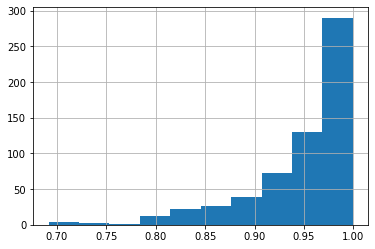

In [11]:
ml.prim_prob.hist()

<AxesSubplot:>

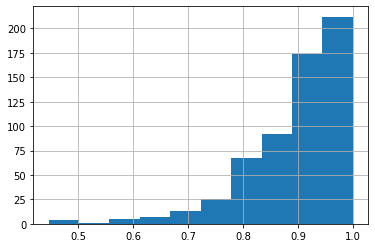

In [12]:
ml.sec_prob.hist()

<AxesSubplot:>

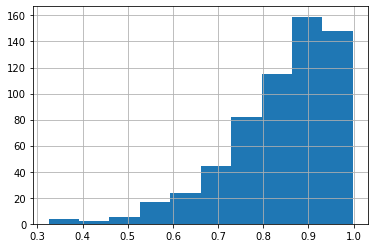

In [13]:
ml.ter_prob.hist()

In [14]:
label_combo = pd.DataFrame(ml[['prim_labels', 
                               'sec_labels', 
                               'ter_labels']].value_counts()).reset_index().rename(columns={0: 'count'})
print(label_combo.shape)
label_combo.head()

# label_combo.to_csv("label_combo.csv", index=False)

(409, 4)


,prim_labels,sec_labels,ter_labels,count
0,Business,Industries,Economy,40
1,Business,Industries,Sales and Promotions,21
2,Business,Economy,Industries,13
3,Business,Industries,Financial Planning,11
4,Business,Sales and Promotions,Industries,10


* **Scalable (non-Manual) filtering**

In [20]:
Generate embeddings using avg(sbert)

import joblib
from joblib import Parallel, delayed
from nltk.tokenize import sent_tokenize
from sentence_transformers import SentenceTransformer

def get_embeddings_mod(article_body):
    '''
    For a given article:
    1. Using SentenceTransformer, extracts every sentence's embedding
    2. Averages those embeddings to get one final article-level embedding
    '''
    
    model = SentenceTransformer('all-distilroberta-v1') #distilbert-base-nli-mean-tokens  -- this model is deprecated now 9/9/21
    
    art_sentences = sent_tokenize(article_body)
    
    embedding_sent = model.encode(art_sentences)    

    art_embed = np.mean(embedding_sent, axis=0)
    
    return art_embed



ml.reset_index(drop=True, inplace=True)

df_proc = ml.clean_summary.tolist()
print("articles: ", len(df_proc))

# Parallel processing

start = time.time()

article_embeddings = Parallel(n_jobs=-1)(delayed(get_embeddings_mod)(article_body) for article_body in df_proc)

print("article_embeddings len:", len(article_embeddings))
print()
print('Embedding generation time {} minutes'.format(round((time.time() - start) / 60, 2)))

articles:  600
article_embeddings len: 600

Embedding generation time 1.56 minutes


In [21]:
ml["label_combo"] = ml["prim_labels"] + " " + ml["sec_labels"] + " " + ml["ter_labels"]

In [22]:
def topic_cos_sim_metrics(embedding_list):
    '''
    a. Calculate cosine similarity of every article (embedding_list) with every other. 
    b. Calculate stats (min, mean etc.) on above
    '''
    
    # convert list to sparse matrix
    sparse_matrix= scipy.sparse.csr_matrix(embedding_list)
    
    # full matrix of cosine similarity of every embedding/article with every other
    cos_mat = cosine_similarity(sparse_matrix)
    
    # keep upper right triangle (above diagonal)
    upper_right = cos_mat[np.triu_indices(len(embedding_list), k=1)]
    
    # calculate metrics
    metrics = pd.DataFrame(upper_right
                          ).describe().T.apply(lambda x: 
                                               round(x, 2)).rename(columns={"min":"cos_min",
                                                                            "mean":"cos_mean",
                                                                            "std":"cos_std", 
                                                                            "50%":"cos_median"})[["cos_min", "cos_mean"]]
    
    return metrics


In [23]:
cossim_matrix_df = pd.DataFrame()
topic_num_list = []

for topic_num in sorted(ml.label_combo.unique()):

    topic_group = ml[ml.label_combo== topic_num]
    # grab all articles of given label combo
    group_embeddings = [article_embeddings[i] for i in list(topic_group.index)]

    # generate cosine similarity metrics for each label combo
    metrics_df = topic_cos_sim_metrics(group_embeddings)

    # append all topic metrics together
    cossim_matrix_df = cossim_matrix_df.append(metrics_df)

    # make a label combo list
    topic_num_list.append(topic_num)

cossim_matrix_df["label_combo"] = topic_num_list

cols = ['label_combo', 'cos_min', 'cos_mean']

cossim_matrix_df = cossim_matrix_df[cols].reset_index(drop=True) #9.56

In [24]:
ml.label_combo.value_counts()

Business Industries Economy                            40
Business Industries Sales and Promotions               21
Business Economy Industries                            13
Business Industries Financial Planning                 11
Business Sales and Promotions Industries               10
                                                       ..
Content Production Comics and Graphic Novels Design     1
Business Senior Health Industries                       1
Wellness Women's Health Diseases and Conditions         1
Computing Digital Arts Consumer Electronics             1
Hotel Properties Travel Locations Business              1
Name: label_combo, Length: 409, dtype: int64

In [25]:
vis = cossim_matrix_df[cossim_matrix_df.cos_min.notna()] 
# this shows just the combos having rows > 1
vis

,label_combo,cos_min,cos_mean
2,Alcoholic Beverages Business Industries,0.7,0.7
26,Auto Technology Industries Business,0.5,0.5
31,Baseball Business American Football,0.7,0.7
33,Basketball Business College Sports,0.7,0.7
34,Basketball College Sports Business,0.7,0.7
41,Biological Sciences Environment Parks & Nature,0.3,0.5
50,Business Alcoholic Beverages Industries,0.5,0.6
53,Business Auto Technology Auto Buying and Selling,0.5,0.5
57,Business Career Advice Career Planning,0.8,0.8
60,Business Career Planning Career Advice,0.4,0.4


In [26]:
vis.describe()

,cos_min,cos_mean
count,59.0,59.0
mean,0.5,0.6
std,0.2,0.1
min,0.1,0.4
25%,0.4,0.5
50%,0.5,0.5
75%,0.6,0.6
max,0.8,0.8


<AxesSubplot:>

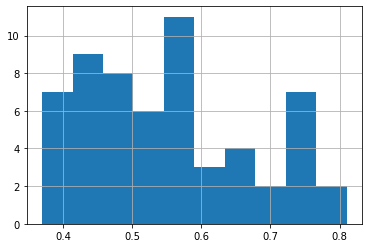

In [28]:
vis.cos_mean.hist()

In [29]:
vis[vis.cos_mean > 0.6]

,label_combo,cos_min,cos_mean
2,Alcoholic Beverages Business Industries,0.7,0.7
31,Baseball Business American Football,0.7,0.7
33,Basketball Business College Sports,0.7,0.7
34,Basketball College Sports Business,0.7,0.7
57,Business Career Advice Career Planning,0.8,0.8
63,Business Computing Industries,0.6,0.7
85,Business Industries Auto Buying and Selling,0.5,0.7
90,Business Industries Consumer Electronics,0.6,0.6
143,College Education Adult Education Business,0.8,0.8
211,Diseases and Conditions Vaccines Biological Sciences,0.6,0.7


In [36]:
merged = pd.merge(ml, 
                  cossim_matrix_df, 
                  on='label_combo',
                  how='left')

print(merged[merged.cos_min>0.6].sort_values("label_combo").shape)

(31, 14)


In [33]:
merged[merged.label_combo=='Diseases and Conditions Vaccines Biological Sciences']

,natid,category,tier1,tier2,clean_summary,prim_labels,sec_labels,ter_labels,prim_prob,sec_prob,ter_prob,label_combo,cos_min,cos_mean
10,blogandpostid/blog/post/50462-6107e4b6b4025a00076df887,News and Politics,Medical Health,Diseases and Conditions,"delta surge wipes away americans' optimism covid, poll shows expecting disruptions 2022. topline months mounting hope, americans' optimism covid-1...",Diseases and Conditions,Vaccines,Biological Sciences,1.0,1.0,0.5,Diseases and Conditions Vaccines Biological Sciences,0.6,0.7
374,blogandpostid/blog/post/50462-60fffbe699faf30006eb8e06,Medical Health,Medical Health,Vaccines,cdc reinstate mask guidance vaccinated americans certain circumstances. topline centers disease control prevention (cdc) expected announce new gui...,Diseases and Conditions,Vaccines,Biological Sciences,1.0,1.0,0.5,Diseases and Conditions Vaccines Biological Sciences,0.6,0.7
443,blogandpostid/blog/post/2125-5f99c61557b2f80006b1b548,News and Politics,Style & Fashion,Beauty,"fauci: aside politics mask. nationwide use face masks bring spread covid-19 control 90% 95% usa population wore face coverings, dr. anthony fauci ...",Diseases and Conditions,Vaccines,Biological Sciences,1.0,0.9,0.7,Diseases and Conditions Vaccines Biological Sciences,0.6,0.7


In [35]:
merged[merged.label_combo=='Wrestling Business Sports TV']

,natid,category,tier1,tier2,clean_summary,prim_labels,sec_labels,ter_labels,prim_prob,sec_prob,ter_prob,label_combo,cos_min,cos_mean
154,blogandpostid/blog/post/3951-5fdf9de90208480006cd1d7e,Sports,Sports,Wrestling,"charlotte flair returns wwe tlc 2020 twitter explodes tears, cheers. charlotte flair returned wwe tlc 2020 asuka's mystery tag team partner. pair ...",Wrestling,Business,Sports TV,1.0,0.9,0.9,Wrestling Business Sports TV,0.7,0.7
527,blogandpostid/blog/post/3951-5fe15740fa09d70007569a43,Sports,Sports,Wrestling,"wwe raw predictably counters record-low ratings legends night'. wwe announced legends night, special edition raw weeks. (emergency) special-editio...",Wrestling,Business,Sports TV,1.0,1.0,0.9,Wrestling Business Sports TV,0.7,0.7


In [37]:
vis[vis.cos_mean < 0.5]

,label_combo,cos_min,cos_mean
26,Auto Technology Industries Business,0.5,0.5
41,Biological Sciences Environment Parks & Nature,0.3,0.5
60,Business Career Planning Career Advice,0.4,0.4
68,Business Content Production Industries,0.5,0.5
73,Business Economy Industries,0.1,0.5
78,Business Financial Planning Economy,0.4,0.4
81,Business Financial Planning Real Estate Buying and Selling,0.5,0.5
92,Business Industries Design,0.5,0.5
94,Business Industries Economy,0.1,0.5
95,Business Industries Financial Planning,0.2,0.4


In [39]:
# Remove "highly dissimilar articles" from the group like "Are People Keen To Get Back To Their Commute? (481 index)"

merged[merged.label_combo =='Business Economy Industries']

,natid,category,tier1,tier2,clean_summary,prim_labels,sec_labels,ter_labels,prim_prob,sec_prob,ter_prob,label_combo,cos_min,cos_mean
11,blogandpostid/blog/post/3863-60dcd45a7586ad000631ba9e,Business and Finance,Business and Finance,Business,"rising costs salaries present challenges small businesses. pandemic restrictions ease, small business owners discovering incredibly competitive ta...",Business,Economy,Industries,1.0,1.0,1.0,Business Economy Industries,0.1,0.5
157,blogandpostid/blog/post/51070-611bcd2be4e302000613ff2c,Business and Finance,Education,College Education,"black-owned mobile platform, athlytic, allows student-athletes monetize name, image, likeness. june 30 - 115 years formal establishment - ncaa sus...",Business,Economy,Industries,0.9,0.8,0.8,Business Economy Industries,0.1,0.5
163,blogandpostid/blog/post/6031-5fb6bdae8ac91b00069ff2b6,Real Estate,Home & Garden,Interior Decorating,"recycle kitchen world better place. steve feldman veteran rock roll disc jockey who, 1998, left radio raise money addict recovery programs. self-p...",Business,Economy,Industries,0.9,0.9,0.9,Business Economy Industries,0.1,0.5
175,blogandpostid/blog/post/7021-5fbd05262633270006cfd9ae,Business and Finance,Business and Finance,Business,"multi-stakeholder capitalism pay investors america. america lead accelerating green economy power new green infrastructure, support local communit...",Business,Economy,Industries,1.0,1.0,0.9,Business Economy Industries,0.1,0.5
187,blogandpostid/blog/post/50701-605c55376f829f000699193f,Business and Finance,Food & Drink,Dining Out,"black restaurant week celebrates flavors african-american, african, caribbean cuisine. eye city's restaurant week year, heard black restaurant wee...",Business,Economy,Industries,1.0,0.9,0.9,Business Economy Industries,0.1,0.5
222,blogandpostid/blog/post/50933-600dddf8cdf82b00064d766a,Business and Finance,Business and Finance,Business,"riding esg juggernaut: business it, anyway?. new administration's commitment environmental, social, governance ( esg ) issues begs question busine...",Business,Economy,Industries,1.0,0.9,0.9,Business Economy Industries,0.1,0.5
246,blogandpostid/blog/post/5692-611064b2d7faf400072dd53b,Business and Finance,Education,Homework and Study,"workplace going problem solver?. microsoft, google, facebook, united airlines, cisco, tysons foods, walgreens, washington post, netflx productions...",Business,Economy,Industries,0.9,0.9,0.9,Business Economy Industries,0.1,0.5
270,blogandpostid/blog/post/51094-60901488c069bd0006e4b2a6,Science,Science,Environment,"weather data helps businesses address challenges climate change. climate change forefront american minds. priority biden administration, recently ...",Business,Economy,Industries,1.0,1.0,0.9,Business Economy Industries,0.1,0.5
310,blogandpostid/blog/post/2210-60feb3cb18a8180006721a55,Personal Finance,Personal Finance,Personal Investing,"earnings palooza: week includes one-third s&p 500 earnings, fed meeting. key takeaways: week ahead includes earnings 180 s&p 500 companies amazon ...",Business,Economy,Industries,1.0,0.9,0.8,Business Economy Industries,0.1,0.5
475,blogandpostid/blog/post/5682-5ff33c88cd17230006f7e29e,Healthy Living,Shopping,Holiday Shopping,"simple secret entrepreneur uses new year's resolutions stick. is' season instagram ad offer solution new year's resolutions - saving money, dietin...",Business,Economy,Industries,0.9,0.8,0.8,Business Economy Industries,0.1,0.5


* Next steps - 
    * since none of parallelization techniques worked -- make VM - run it for 1-2 days 
        * provide "category" as its most granular - get a few thousand articles' labels
    * Meanwhile - work on other methods
    * Decide whether to ensemble or post-process
    
Real test - build classifier and see performance

In [ ]:
9/21

# IDEA - get author bios? -- content table, author table
# Features: feed author name, topics, sentiment 

# Received Direction - 
# go ahead with zero-shot tier2?
# ensemble and including author bios is good idea